In [85]:
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
my_red = "#f53b3b" # red
my_blue = "#4287f5" # blue

In [91]:
num_nodes = 200
mean_degree = 10
ythreshold = 0.1 #threshold on eigenvector components

In [92]:
m = int(mean_degree/2)  
ba_graph = ig.Graph.Barabasi(n=num_nodes, m=m)
degrees = ba_graph.degree()
sorted_indices = sorted(range(len(degrees)), key=lambda k: degrees[k], reverse=True)
new_indices = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}
reindexed_edges = [(new_indices[edge.source], new_indices[edge.target]) for edge in ba_graph.es]

graph = ig.Graph(edges=reindexed_edges)
degrees = graph.degree()
assumed_degrees = np.unique(degrees) # np.unique(degrees) automatically sorts in increasing order
laplacian_matrix = np.array(graph.laplacian())
eigenvalues, eigenvectors = np.linalg.eigh(laplacian_matrix) # L = D-Alaplacian_matrix = np.array(graph.laplacian())

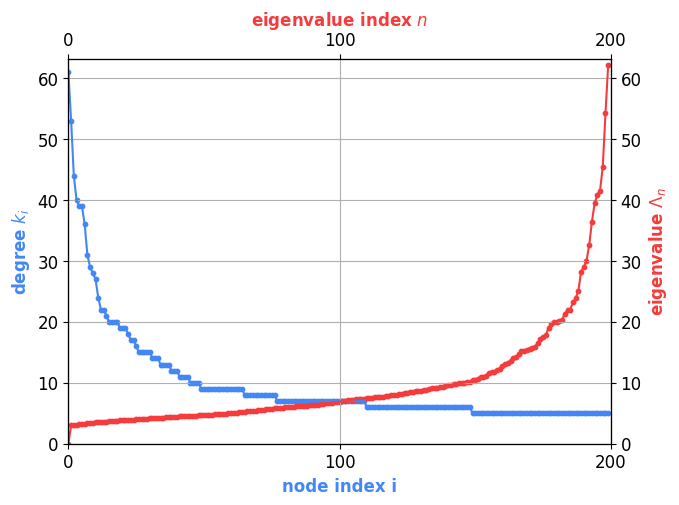

In [93]:
## Plot Graphs and Degree Distribution
layout = graph.layout("fruchterman_reingold")  # Kamada-Kawai layout

fig, axs = plt.subplots(figsize=(7, 5)) 
#ig.plot(
#    graph, 
#    layout=layout, 
#    target=axs[0], 
#    bbox=(800, 800), 
#    margin=20, 
#    vertex_size=3,
#    edge_width=0.1,
#    vertex_color = 'black',
#    vertex_frame_color = 'black'
#)
#axs[0].set_title(f"BA Network with N={num_nodes}, <k> = {mean_degree}")

c = "#4287f5" # blue
axs.plot(
    range(num_nodes),
    degrees,
    color=c,
    )
axs.scatter(
    range(num_nodes),
    degrees,
    color=c,
    s = 10
    )
axs.set_xlabel("node index i",  color = "#4287f5", fontdict={'weight': 'bold'}, fontsize = 12)
axs.set_ylabel(r"degree $k_i$", color = "#4287f5", fontdict={'weight': 'bold'}, fontsize = 12)

######################################################################################
c = "#f53b3b" # red
secax_x = axs.twiny()
secax_x.set_xlabel(r"eigenvalue index $n$", color=c, fontdict={'weight': 'bold'}, fontsize = 12)
secax_x.xaxis.set_label_position('top')
axs.set_xlim(0, num_nodes)
secax_x.set_xlim(0, num_nodes)

axs.set_xticks(np.arange(0, num_nodes + 1, 100, dtype = int))
axs.set_xticklabels(np.arange(0, num_nodes + 1, 100, dtype = int), fontsize = 12)
secax_x.set_xticks(np.arange(0, num_nodes + 1, 100, dtype = int))
secax_x.set_xticklabels(np.arange(0, num_nodes + 1, 100, dtype = int), fontsize = 12)



secax_y = axs.twinx()
secax_y.set_ylabel(r"eigenvalue $\Lambda_n$", color="#f53b3b", fontdict={'weight': 'bold'}, fontsize = 12)
secax_y.yaxis.set_label_position('right')
upper_limits = [max(degrees), max(eigenvalues)]
axs.set_ylim(0, max(upper_limits)+1)
secax_y.set_ylim(0, max(upper_limits)+1)


axs.set_yticks(np.arange(0, max(degrees), 10, dtype = int))
axs.set_yticklabels(np.arange(0, max(degrees), 10, dtype = int), fontsize = 12)
secax_y.set_yticks(np.arange(0, max(degrees), 10, dtype = int))
secax_y.set_yticklabels(np.arange(0, max(degrees), 10, dtype = int), fontsize = 12)



axs.plot(
    range(num_nodes),
    eigenvalues,
    color=c,
    )
axs.scatter(
    range(num_nodes),
    eigenvalues,
    color=c,
    s = 10
    )
#plt.suptitle("Degree and Eigenvalues Spectrum", fontsize = 16, y = 1.1)
#axs.set_title(f"BA Network with N = {num_nodes}, <k> = {mean_degree}", fontsize = 14, y = 1.15)
axs.grid(True)
plt.savefig(f"figures/network_{num_nodes}.pdf")

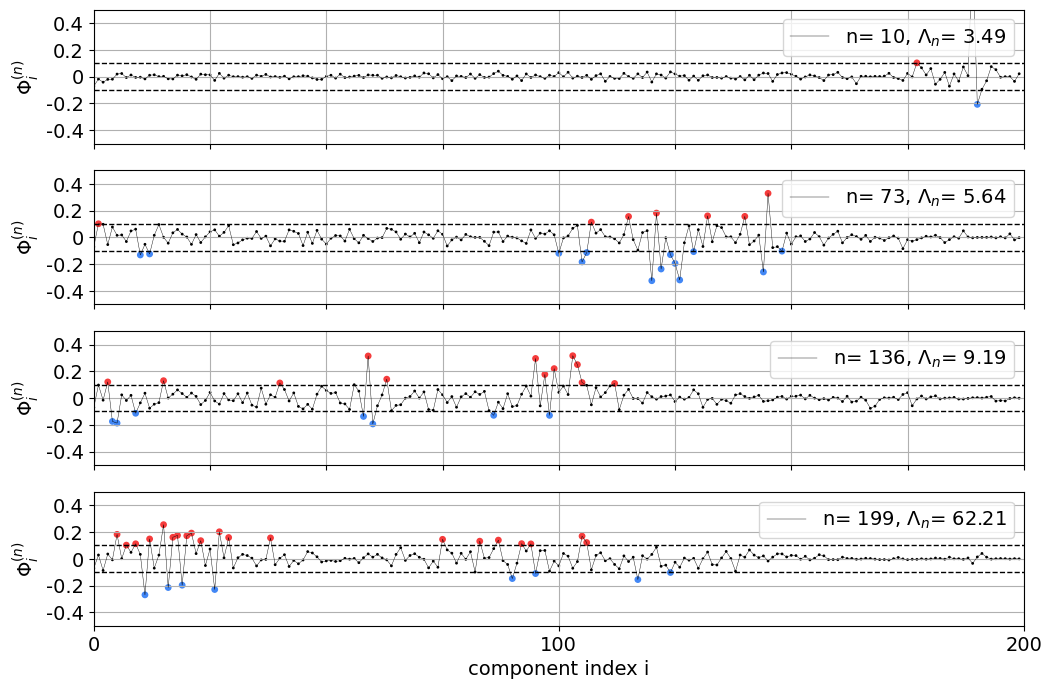

In [94]:
indices = [int(x) for x in np.linspace(10, num_nodes-1, 4)]

fig, axs = plt.subplots(len(indices), 1, figsize=(12, 8)) 
#plt.suptitle(f"Eigenvector Localization on BA with {num_nodes} nodes, mean degree <k>={mean_degree}", fontsize = 16)


for i,id in enumerate(indices):
    eigenvector = eigenvectors[id]
    axs[i].plot(
        range(num_nodes),
        [eigenvector[n] for n in range(num_nodes)],
        color="black",
        linewidth = 0.3,
        )
    colors = []
    sizes = []
    for a in np.arange(0, num_nodes):
        if eigenvector[a] > ythreshold:
            colors.append(my_red)
            sizes.append(15)
        elif eigenvector[a] < -ythreshold:
            colors.append(my_blue)
            sizes.append(15)
        else:
            colors.append('black')
            sizes.append(1)

    axs[i].scatter(range(num_nodes), [eigenvector[n] for n in range(num_nodes)], color = colors, s = sizes)
    axs[i].set_xlim(0, num_nodes)
    axs[i].set_ylim(-0.5, +0.5)
    axs[i].set_xlabel("")
    axs[i].set_ylabel(r"$\Phi_i^{(n)}$", fontsize = 14)
    axs[i].legend([rf"n= {id}, $\Lambda_n$= {eigenvalues[id]:.2f}"], loc='upper right', fontsize = 14)
    axs[i].axhline(y= + ythreshold, color='black', linestyle='--', linewidth = 1)
    axs[i].axhline(y=- ythreshold, color='black', linestyle='--', linewidth = 1)
    axs[i].grid()
    axs[i].set_xticklabels("")
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    axs[i].set_yticks([-0.4, -0.2, 0, 0.2, 0.4])
    axs[i].set_yticklabels([-0.4, -0.2, 0, 0.2, 0.4], fontsize = 14)
    
axs[len(indices) - 1].set_xticks(np.arange(0, num_nodes + 1, 100))    
axs[len(indices) - 1].set_xticklabels(np.arange(0, num_nodes + 1, 100), fontsize = 14)
axs[len(indices)-1].set_xlabel("component index i", fontsize = 14)
plt.savefig(f"figures/eigenvectors_{num_nodes}.pdf")

In [83]:
x_min = m
x_max = 40
binwidth = 1
n_bins = (x_max - x_min)/ binwidth

data = []
k_groups_populations = []
running_degrees = np.arange(x_min, x_max + 1)
for k in running_degrees:
    n_k = 0
    for i in np.arange(0, num_nodes):
        if degrees[i] == k:
            n_k += 1
    k_groups_populations.append(n_k)

for i, eig in enumerate(eigenvalues):
    v = eigenvectors[i]
    for k_index, k in enumerate(running_degrees):
        if k_groups_populations[k_index] != 0:
            n_k = 0
            for n in np.arange(0, num_nodes):
                if (degrees[n] == k) and (abs(v[n]) > ythreshold):
                    n_k += 1
            density = n_k/k_groups_populations[k_index]
        else:
            density = 0
        data.append({'eigenvalue_index': i, 'eigenvalue': eig, 'degree': k , 'number': n_k, 'density': density})
df = pd.DataFrame(data)
#df.to_csv("csv_outputs/prova.csv")


data = []
for k in running_degrees:
    temp = df[df['degree'] == k].copy()
    for bin_index in np.arange(0, n_bins + 1):
        inf = x_min + bin_index * binwidth
        bis_temp = temp[temp['eigenvalue'] <= (inf + binwidth)].copy()
        bis_temp = bis_temp[bis_temp['eigenvalue'] >= inf]
        mean = np.mean(bis_temp['density'])
        data.append({'degree': k, 'eigenvalue': inf, 'mean_density': mean})

df = pd.DataFrame(data)
df.to_csv(f'csv_outputs/binned_{num_nodes}.csv', index=False)

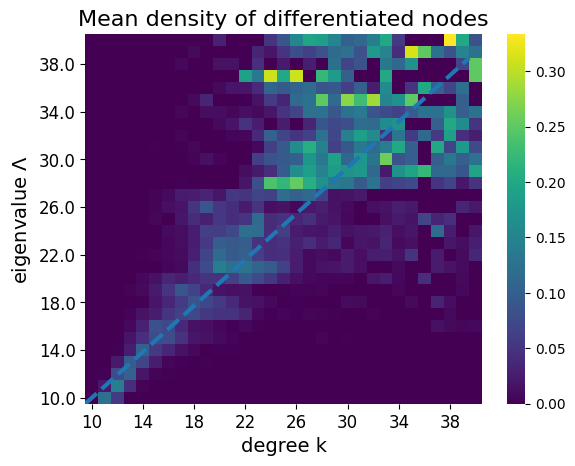

In [84]:
pivot_table = df.pivot_table(index='eigenvalue', columns='degree', values='mean_density', aggfunc='mean')

fig, ax = plt.subplots()
plt.title('Mean density of differentiated nodes', fontsize = 16)
sns.heatmap(pivot_table,
            cmap='viridis',
            ax=ax,
            xticklabels= '',
            yticklabels= '',
            )
ax.invert_yaxis()
ax.set_xlabel('degree k', fontsize = 14)
ax.set_ylabel(r'eigenvalue $\Lambda$', fontsize = 14)
ax.set_xticks(np.arange(0.5, n_bins, 4))
ax.set_xticklabels([int(m+i) for i in np.arange(0, n_bins, 4)], rotation = 0, fontsize = 12)
ax.set_yticks(np.arange(0.5, n_bins-1, 4))
ax.set_yticklabels([m+i for i in np.arange(0, n_bins-1, 4)], rotation = 0, fontsize = 12)


x = np.linspace(0, n_bins, 100)
y = [x for x in np.linspace(0, n_bins - 1, 100)]
plt.plot(x, y, linestyle= 'dashed', linewidth = 3)

plt.savefig(f"figures/density_{num_nodes}.pdf")
plt.show()